In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering, KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
import colorsys
from datetime import datetime

pd.set_option('display.max_columns', None)

Import data

In [2]:
data = pd.read_csv("../data/numeric_data.csv", sep=";", on_bad_lines='skip', decimal=',', dtype = {'production_order_code [None]': 'Int64', 'product_code [None]': 'Int64'}).dropna(subset=['production_order_code [None]'])
data['local_time'] = pd.to_datetime(data['local_time'], format="%Y.%m.%d %H:%M:")

/var/folders/wb/ds0bcygd1bz7hr_3nm8mcg_c0000gn/T/ipykernel_12656/1016689066.py:1: DtypeWarning: Columns (227,228,229,241,242,243,244,245,246) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../data/numeric_data.csv", sep=";", on_bad_lines='skip', decimal=',', dtype = {'production_order_code [None]': 'Int64', 'product_code [None]': 'Int64'}).dropna(subset=['production_order_code [None]'])


In [3]:
data

,local_time,product_code [None],production_order_code [None],Abzug Flachlegung [mm],Abzug Zentralführung [mm],Anlage Stillstandsgrund [-],Auftrag Länge (Soll) [m],Außenluft 1 [%],Bahngeschwindigkeit [m/min],Blaskopf Zone 1 Temperatur (Soll) [°C],Blaskopf Zone 1 Temperatur [°C],Blaskopf Zone 10 Temperatur (Soll) [°C],Blaskopf Zone 10 Temperatur [°C],Blaskopf Zone 2 Temperatur (Soll) [°C],Blaskopf Zone 2 Temperatur [°C],Blaskopf Zone 3 Temperatur (Soll) [°C],Blaskopf Zone 3 Temperatur [°C],Blaskopf Zone 4 Temperatur (Soll) [°C],Blaskopf Zone 4 Temperatur [°C],Blaskopf Zone 5 Temperatur (Soll) [°C],Blaskopf Zone 5 Temperatur [°C],Blaskopf Zone 6 Temperatur (Soll) [°C],Blaskopf Zone 6 Temperatur [°C],Blaskopf Zone 7 Temperatur (Soll) [°C],Blaskopf Zone 7 Temperatur [°C],Blaskopf Zone 8 Temperatur (Soll) [°C],Blaskopf Zone 8 Temperatur [°C],Blaskopf Zone 9 Temperatur (Soll) [°C],Blaskopf Zone 9 Temperatur [°C],Breite (Soll) [mm],Breite [mm],Dickenmessung Zentrierbetrag (diagonal) [%],Dickenmessung Zentrierrichtung (diagonal) [°],Druckluftverbrauch (Soll) [Nm3/h],Druckluftverbrauch [Nm3/h],Durchsatz (Soll) [kg/h],Durchsatz [kg/h],Elektrische Leistung Gesamt [kW],Extruder A AF1 Temperatur (Soll) [°C],Extruder A AF1 Temperatur [°C],Extruder A Dicke (Soll) [µm],Extruder A Drehzahl [1/min],Extruder A Durchsatz [kg/h],Extruder A Förderrate [kg/U/min],Extruder A HK Anteil ( Soll) [%],Extruder A HK Anteil [%],Extruder A HK Dichte [g/ccm],Extruder A HK Durchsatz [kg/h],Extruder A Laufmetergewicht [g/m],Extruder A Massedruck [bar],Extruder A Massetemperatur [°C],Extruder A Motorstrom [A],Extruder A NK 1 Anteil (Soll) [%],Extruder A NK 1 Anteil [%],Extruder A NK 1 Ausstoß maximal (Soll) [kg/h],Extruder A NK 1 Drehzahl [1/min],Extruder A NK 1 Durchsatz [kg/h],Extruder A NK 2 Anteil (Soll) [%],Extruder A NK 2 Anteil [%],Extruder A NK 2 Ausstoß maximal (Soll) [kg/h],Extruder A NK 2 Drehzahl [1/min],Extruder A NK 2 Durchsatz [kg/h],Extruder A NK 3 Anteil (Soll) [%],Extruder A NK 3 Anteil [%],Extruder A NK 3 Ausstoß maximal (Soll) [kg/h],Extruder A NK 3 Drehzahl [1/min],Extruder A NK 3 Durchsatz [kg/h],Extruder A NK 4 Anteil (Soll) [%],Extruder A NK 4 Anteil [%],Extruder A NK 4 Ausstoß maximal (Soll) [kg/h],Extruder A NK 4 Drehzahl [1/min],Extruder A NK 4 Durchsatz [kg/h],Extruder A NK 5 Anteil (Soll) [%],Extruder A NK 5 Anteil [%],Extruder A NK 5 Ausstoß maximal (Soll) [kg/h],Extruder A NK 5 Drehzahl [1/min],Extruder A NK 5 Durchsatz [kg/h],Extruder A NK1 Dichte [g/ccm],Extruder A NK1 Förderrate [kg/U/min],Extruder A NK2 Dichte [g/ccm],Extruder A NK2 Förderrate [kg/U/min],Extruder A NK3 Dichte [g/ccm],Extruder A NK3 Förderrate [kg/U/min],Extruder A NK4 Dichte [g/ccm],Extruder A NK4 Förderrate [kg/U/min],Extruder A NK5 Dichte [g/ccm],Extruder A NK5 Förderrate [kg/U/min],Extruder A Nutmutter Temperatur (Soll) [°C],Extruder A Nutmutter Temperatur [°C],Extruder A Schichtdicke [µm],Extruder A Siebwechsler Temperatur (Soll) [°C],Extruder A Siebwechsler Temperatur [°C],Extruder A Zone 1 Temperatur (Soll) [°C],Extruder A Zone 1 Temperatur [°C],Extruder A Zone 2 Temperatur (Soll) [°C],Extruder A Zone 2 Temperatur [°C],Extruder A Zone 3 Temperatur (Soll) [°C],Extruder A Zone 3 Temperatur [°C],Extruder A Zone 4 Temperatur (Soll) [°C],Extruder A Zone 4 Temperatur [°C],Extruder B AF1 Temperatur (Soll) [°C],Extruder B AF1 Temperatur [°C],Extruder B Dicke (Soll) [µm],Extruder B Drehzahl [1/min],Extruder B Durchsatz [kg/h],Extruder B Förderrate [kg/U/min],Extruder B HK Anteil (Soll) [%],Extruder B HK Anteil [%],Extruder B HK Dichte [g/ccm],Extruder B HK Durchsatz [kg/h],Extruder B Laufmetergewicht [g/m],Extruder B Massedruck [bar],Extruder B Massetemperatur [°C],Extruder B Motorstrom [A],Extruder B NK 1 Anteil (Soll) [%],Extruder B NK 1 Anteil [%],Extruder B NK 1 Ausstoß maximal (Soll) [kg/h],Extruder B NK 1 Drehzahl [1/min],Extruder B NK 1 Durchsatz [kg/h],Extruder B NK 2 Anteil (Soll) [%],Extruder B NK 2 Anteil [%],Extruder B NK 2 Ausstoß maximal (Soll) [kg/h]

In [4]:
col_search_words = ['Anteil', 'Material']

# Select columns containing any word from the list
repipe_columns = [col for col in data.columns if any(word in col for word in col_search_words)]
cols_without_recipe_cols = [col for col in data.columns if col not in repipe_columns]
data_without_recipe_cols = data[cols_without_recipe_cols]

Standardize data

In [5]:
general_data = data_without_recipe_cols.iloc[:, :3] # local_time, product_code and production_order_code
feature_data = data_without_recipe_cols.iloc[:, 3:] 

scaler = StandardScaler()
scaler.fit(feature_data)

standardized_data = pd.concat([general_data, pd.DataFrame(scaler.transform(feature_data), columns=feature_data.columns.to_list())], axis=1)
standardized_data

,local_time,product_code [None],production_order_code [None],Abzug Flachlegung [mm],Abzug Zentralführung [mm],Anlage Stillstandsgrund [-],Auftrag Länge (Soll) [m],Außenluft 1 [%],Bahngeschwindigkeit [m/min],Blaskopf Zone 1 Temperatur (Soll) [°C],Blaskopf Zone 1 Temperatur [°C],Blaskopf Zone 10 Temperatur (Soll) [°C],Blaskopf Zone 10 Temperatur [°C],Blaskopf Zone 2 Temperatur (Soll) [°C],Blaskopf Zone 2 Temperatur [°C],Blaskopf Zone 3 Temperatur (Soll) [°C],Blaskopf Zone 3 Temperatur [°C],Blaskopf Zone 4 Temperatur (Soll) [°C],Blaskopf Zone 4 Temperatur [°C],Blaskopf Zone 5 Temperatur (Soll) [°C],Blaskopf Zone 5 Temperatur [°C],Blaskopf Zone 6 Temperatur (Soll) [°C],Blaskopf Zone 6 Temperatur [°C],Blaskopf Zone 7 Temperatur (Soll) [°C],Blaskopf Zone 7 Temperatur [°C],Blaskopf Zone 8 Temperatur (Soll) [°C],Blaskopf Zone 8 Temperatur [°C],Blaskopf Zone 9 Temperatur (Soll) [°C],Blaskopf Zone 9 Temperatur [°C],Breite (Soll) [mm],Breite [mm],Dickenmessung Zentrierbetrag (diagonal) [%],Dickenmessung Zentrierrichtung (diagonal) [°],Druckluftverbrauch (Soll) [Nm3/h],Druckluftverbrauch [Nm3/h],Durchsatz (Soll) [kg/h],Durchsatz [kg/h],Elektrische Leistung Gesamt [kW],Extruder A AF1 Temperatur (Soll) [°C],Extruder A AF1 Temperatur [°C],Extruder A Dicke (Soll) [µm],Extruder A Drehzahl [1/min],Extruder A Durchsatz [kg/h],Extruder A Förderrate [kg/U/min],Extruder A HK Dichte [g/ccm],Extruder A HK Durchsatz [kg/h],Extruder A Laufmetergewicht [g/m],Extruder A Massedruck [bar],Extruder A Massetemperatur [°C],Extruder A Motorstrom [A],Extruder A NK 1 Ausstoß maximal (Soll) [kg/h],Extruder A NK 1 Drehzahl [1/min],Extruder A NK 1 Durchsatz [kg/h],Extruder A NK 2 Ausstoß maximal (Soll) [kg/h],Extruder A NK 2 Drehzahl [1/min],Extruder A NK 2 Durchsatz [kg/h],Extruder A NK 3 Ausstoß maximal (Soll) [kg/h],Extruder A NK 3 Drehzahl [1/min],Extruder A NK 3 Durchsatz [kg/h],Extruder A NK 4 Ausstoß maximal (Soll) [kg/h],Extruder A NK 4 Drehzahl [1/min],Extruder A NK 4 Durchsatz [kg/h],Extruder A NK 5 Ausstoß maximal (Soll) [kg/h],Extruder A NK 5 Drehzahl [1/min],Extruder A NK 5 Durchsatz [kg/h],Extruder A NK1 Dichte [g/ccm],Extruder A NK1 Förderrate [kg/U/min],Extruder A NK2 Dichte [g/ccm],Extruder A NK2 Förderrate [kg/U/min],Extruder A NK3 Dichte [g/ccm],Extruder A NK3 Förderrate [kg/U/min],Extruder A NK4 Dichte [g/ccm],Extruder A NK4 Förderrate [kg/U/min],Extruder A NK5 Dichte [g/ccm],Extruder A NK5 Förderrate [kg/U/min],Extruder A Nutmutter Temperatur (Soll) [°C],Extruder A Nutmutter Temperatur [°C],Extruder A Schichtdicke [µm],Extruder A Siebwechsler Temperatur (Soll) [°C],Extruder A Siebwechsler Temperatur [°C],Extruder A Zone 1 Temperatur (Soll) [°C],Extruder A Zone 1 Temperatur [°C],Extruder A Zone 2 Temperatur (Soll) [°C],Extruder A Zone 2 Temperatur [°C],Extruder A Zone 3 Temperatur (Soll) [°C],Extruder A Zone 3 Temperatur [°C],Extruder A Zone 4 Temperatur (Soll) [°C],Extruder A Zone 4 Temperatur [°C],Extruder B AF1 Temperatur (Soll) [°C],Extruder B AF1 Temperatur [°C],Extruder B Dicke (Soll) [µm],Extruder B Drehzahl [1/min],Extruder B Durchsatz [kg/h],Extruder B Förderrate [kg/U/min],Extruder B HK Dichte [g/ccm],Extruder B HK Durchsatz [kg/h],Extruder B Laufmetergewicht [g/m],Extruder B Massedruck [bar],Extruder B Massetemperatur [°C],Extruder B Motorstrom [A],Extruder B NK 1 Ausstoß maximal (Soll) [kg/h],Extruder B NK 1 Drehzahl [1/min],Extruder B NK 1 Durchsatz [kg/h],Extruder B NK 2 Ausstoß maximal (Soll) [kg/h],Extruder B NK 2 Drehzahl [1/min],Extruder B NK 2 Durchsatz [kg/h],Extruder B NK 3 Ausstoß maximal (Soll) [kg/h],Extruder B NK 3 Drehzahl [1/min],Extruder B NK 3 Durchsatz [kg/h],Extruder B NK 4 Ausstoß maximal (Soll) [kg/h],Extruder B NK 4 Drehzahl [1/min],Extruder B NK 4 Durchsatz [kg/h],Extruder B NK 5 Ausstoß maximal (Soll) [kg/h],Extruder B NK 5 Drehzahl [1/min],Extruder B NK 5 Durchsatz [kg/h],Extruder B NK1 Dichte [g/ccm],Extruder B NK1 Förderrate [kg/U/min],Extruder B NK2 Dichte [g/ccm],Extruder B NK2 Förderrate [kg/U/min],Extru

Remove small subset of columns which contain nan values (only 11 features of 300)

In [6]:
standardized_feature_data = standardized_data.iloc[:,3:]
columns_with_nan = standardized_feature_data.columns[standardized_feature_data.isna().any()].tolist()
columns_without_nan = [col for col in standardized_feature_data.columns if col not in columns_with_nan]
standardized_feature_data_without_nan = standardized_feature_data[columns_without_nan]
standardized_feature_data_without_nan

,Abzug Flachlegung [mm],Abzug Zentralführung [mm],Anlage Stillstandsgrund [-],Auftrag Länge (Soll) [m],Außenluft 1 [%],Bahngeschwindigkeit [m/min],Blaskopf Zone 1 Temperatur (Soll) [°C],Blaskopf Zone 1 Temperatur [°C],Blaskopf Zone 10 Temperatur (Soll) [°C],Blaskopf Zone 10 Temperatur [°C],Blaskopf Zone 2 Temperatur (Soll) [°C],Blaskopf Zone 2 Temperatur [°C],Blaskopf Zone 3 Temperatur (Soll) [°C],Blaskopf Zone 3 Temperatur [°C],Blaskopf Zone 4 Temperatur (Soll) [°C],Blaskopf Zone 4 Temperatur [°C],Blaskopf Zone 5 Temperatur (Soll) [°C],Blaskopf Zone 5 Temperatur [°C],Blaskopf Zone 6 Temperatur (Soll) [°C],Blaskopf Zone 6 Temperatur [°C],Blaskopf Zone 7 Temperatur (Soll) [°C],Blaskopf Zone 7 Temperatur [°C],Blaskopf Zone 8 Temperatur (Soll) [°C],Blaskopf Zone 8 Temperatur [°C],Blaskopf Zone 9 Temperatur (Soll) [°C],Blaskopf Zone 9 Temperatur [°C],Breite (Soll) [mm],Breite [mm],Dickenmessung Zentrierbetrag (diagonal) [%],Dickenmessung Zentrierrichtung (diagonal) [°],Druckluftverbrauch (Soll) [Nm3/h],Druckluftverbrauch [Nm3/h],Durchsatz (Soll) [kg/h],Durchsatz [kg/h],Elektrische Leistung Gesamt [kW],Extruder A AF1 Temperatur (Soll) [°C],Extruder A AF1 Temperatur [°C],Extruder A Dicke (Soll) [µm],Extruder A Drehzahl [1/min],Extruder A Durchsatz [kg/h],Extruder A Förderrate [kg/U/min],Extruder A HK Dichte [g/ccm],Extruder A HK Durchsatz [kg/h],Extruder A Laufmetergewicht [g/m],Extruder A Massedruck [bar],Extruder A Massetemperatur [°C],Extruder A Motorstrom [A],Extruder A NK 1 Ausstoß maximal (Soll) [kg/h],Extruder A NK 1 Drehzahl [1/min],Extruder A NK 1 Durchsatz [kg/h],Extruder A NK 2 Ausstoß maximal (Soll) [kg/h],Extruder A NK 2 Drehzahl [1/min],Extruder A NK 2 Durchsatz [kg/h],Extruder A NK 3 Ausstoß maximal (Soll) [kg/h],Extruder A NK 3 Drehzahl [1/min],Extruder A NK 3 Durchsatz [kg/h],Extruder A NK 4 Ausstoß maximal (Soll) [kg/h],Extruder A NK 4 Drehzahl [1/min],Extruder A NK 4 Durchsatz [kg/h],Extruder A NK 5 Ausstoß maximal (Soll) [kg/h],Extruder A NK 5 Drehzahl [1/min],Extruder A NK 5 Durchsatz [kg/h],Extruder A NK1 Dichte [g/ccm],Extruder A NK1 Förderrate [kg/U/min],Extruder A NK2 Dichte [g/ccm],Extruder A NK2 Förderrate [kg/U/min],Extruder A NK3 Dichte [g/ccm],Extruder A NK3 Förderrate [kg/U/min],Extruder A NK4 Dichte [g/ccm],Extruder A NK4 Förderrate [kg/U/min],Extruder A NK5 Dichte [g/ccm],Extruder A NK5 Förderrate [kg/U/min],Extruder A Nutmutter Temperatur (Soll) [°C],Extruder A Nutmutter Temperatur [°C],Extruder A Schichtdicke [µm],Extruder A Siebwechsler Temperatur (Soll) [°C],Extruder A Siebwechsler Temperatur [°C],Extruder A Zone 1 Temperatur (Soll) [°C],Extruder A Zone 1 Temperatur [°C],Extruder A Zone 2 Temperatur (Soll) [°C],Extruder A Zone 2 Temperatur [°C],Extruder A Zone 3 Temperatur (Soll) [°C],Extruder A Zone 3 Temperatur [°C],Extruder A Zone 4 Temperatur (Soll) [°C],Extruder A Zone 4 Temperatur [°C],Extruder B AF1 Temperatur (Soll) [°C],Extruder B AF1 Temperatur [°C],Extruder B Dicke (Soll) [µm],Extruder B Drehzahl [1/min],Extruder B Durchsatz [kg/h],Extruder B Förderrate [kg/U/min],Extruder B HK Dichte [g/ccm],Extruder B HK Durchsatz [kg/h],Extruder B Laufmetergewicht [g/m],Extruder B Massedruck [bar],Extruder B Massetemperatur [°C],Extruder B Motorstrom [A],Extruder B NK 1 Ausstoß maximal (Soll) [kg/h],Extruder B NK 1 Drehzahl [1/min],Extruder B NK 1 Durchsatz [kg/h],Extruder B NK 2 Ausstoß maximal (Soll) [kg/h],Extruder B NK 2 Drehzahl [1/min],Extruder B NK 2 Durchsatz [kg/h],Extruder B NK 3 Ausstoß maximal (Soll) [kg/h],Extruder B NK 3 Drehzahl [1/min],Extruder B NK 3 Durchsatz [kg/h],Extruder B NK 4 Ausstoß maximal (Soll) [kg/h],Extruder B NK 4 Drehzahl [1/min],Extruder B NK 4 Durchsatz [kg/h],Extruder B NK 5 Ausstoß maximal (Soll) [kg/h],Extruder B NK 5 Drehzahl [1/min],Extruder B NK 5 Durchsatz [kg/h],Extruder B NK1 Dichte [g/ccm],Extruder B NK1 Förderrate [kg/U/min],Extruder B NK2 Dichte [g/ccm],Extruder B NK2 Förderrate [kg/U/min],Extruder B NK3 Dichte [g/ccm],Extruder B NK3 Förderrate [kg/U/min

In [11]:
count_within_range = ((standardized_feature_data_without_nan >= -1) & (standardized_feature_data_without_nan <= 1)).sum().sum()

# Count the total number of entries in the DataFrame
total_entries = standardized_feature_data_without_nan.size

# Calculate the percentage
percentage_within_range = (count_within_range / total_entries) * 100
percentage_within_range

81.37270917625213

Reduce Dimensionality

In [15]:
pca = PCA(n_components=0.95)
pca_data = pd.DataFrame(data=pca.fit_transform(standardized_feature_data_without_nan))
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_
pca_components = pca.components_
loadings = pd.DataFrame(data=pca_components, columns=standardized_feature_data_without_nan.columns)
pca_data = pd.concat([standardized_data.iloc[:,:3], pca_data], axis=1)
pca_data

,local_time,product_code [None],production_order_code [None],0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,2022-04-25 14:11:00,94704621,3180622802,4.520385,-4.783623,-4.246073,0.438597,0.447892,-2.889284,1.608585,-4.966211,2.209687,8.918725,0.366771,-3.018074,-1.654632,-5.567474,3.891224,-4.721732,-1.570414,-3.944761,1.286797,2.429665,-0.679718,-1.926108,-2.092146,1.953832,0.215725,-0.485858,-0.618547,0.909752,-0.935409,0.519688,-1.726556,0.596930,0.006086,0.990925,0.588663,-1.167807,0.009019,-1.367662,1.537781,-1.592575,1.230599,-0.457084,-0.952203,-0.779795,1.017678,0.210633,0.787113,-0.358332
1,2022-04-25 14:11:00,94704621,3180622802,4.526012,-4.748765,-4.249470,0.453910,0.404145,-2.855619,1.612156,-4.989121,2.191391,8.956751,0.350636,-2.985733,-1.663076,-5.545301,3.893046,-4.748263,-1.502076,-3.964466,1.319017,2.452196,-0.598590,-1.935946,-2.160521,1.921787,0.209658,-0.521062,-0.559844,0.965628,-1.010884,0.489501,-1.716011,0.435393,-0.082988,0.954068,0.627249,-1.196013,-0.039461,-1.282189,1.520514,-1.766308,1.262138,-0.528803,-0.987599,-0.947199,1.139189,0.085184,0.783776,-0.354517
2,2022-04-25 14:11:00,94704621,3180622802,4.526177,-4.733060,-4.223223,0.461242,0.383454,-2.862759,1.636798,-4.989098,2.165501,8.970821,0.346151,-2.991639,-1.676267,-5.494525,3.924436,-4.755772,-1.473887,-3.955761,1.304101,2.456136,-0.505565,-1.950849,-2.228276,1.909086,0.253943,-0.499190,-0.542053,0.971621,-1.021685,0.467290,-1.641026,0.371043,-0.160422,0.958923,0.675697,-1.157165,-0.156614,-1.262652,1.475785,-1.811365,1.278097,-0.553940,-0.979139,-1.031850,1.161483,0.056717,0.730642,-0.330178
3,2022-04-25 14:12:00,94704621,3180622802,4.528636,-4.727080,-4.245401,0.460298,0.398380,-2.851859,1.631750,-4.983797,2.168383,8.975206,0.334871,-2.986930,-1.679925,-5.505564,3.926994,-4.772456,-1.471816,-3.957893,1.308396,2.484482,-0.506399,-1.950683,-2.249951,1.944560,0.252964,-0.522192,-0.528478,0.945302,-0.999745,0.502786,-1.635893,0.359822,-0.143400,0.965137,0.673930,-1.196598,-0.142821,-1.257508,1.472575,-1.818461,1.296062,-0.539859,-1.025677,-1.084075,1.188281,0.015145,0.761499,-0.316259
4,2022-04-25 14:12:00,94704621,3180622802,4.531014,-4.747627,-4.248447,0.460634,0.368345,-2.842795,1.649026,-4.998431,2.181291,8.993650,0.358956,-2.960074,-1.660673,-5.512106,3.893388,-4.755306,-1.455561,-3.984499,1.326759,2.442459,-0.520897,-1.956155,-2.209240,1.856700,0.204039,-0.541622,-0.536142,1.034196,-1.081419,0.425099,-1.693508,0.292064,-0.148835,0.952368,0.713358,-1.181626,-0.108408,-1.224023,1.493532,-1.874086,1.274447,-0.602277,-0.965645,-1.042075,1.203341,0.027896,0.736649,-0.352737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
663722,2022-07-11 13:48:00,94106158,50172975,1.673398,0.707112,9.126108,0.764490,3.986523,-1.813809,2.811372,2.485620,0.875339,0.867203,-2.198675,-2.121049,-1.063647,-2.148151,0.001066,0.459589,-1.164655,2.301033,0.281833,1.110711,-0.216038,1.232746,-0.453510,-0.206434,-1.143040,1.105197,-2.065660,-0.724978,0.745243,2.737155,-1.206073,-1.204503,-0.320055,0.942734,0.400327,-1.940827,-0.579215,-1.037827,0.826452,0.033533,1.054389,0.504280,0.483758,-0.554645,-0.173499,-0.424314,0.142275,-0.089924
663723,2022-07-11 13:48:00,94106158,50172975,1.649577,0.715685,9.116153,0.783715,4.004210,-1.793150,2.809778,2.461608,0.826261,0.919431,-2.165277,-2.084289,-1.053835,-2.204758,0.026149,0.443792,-1.143790,2.262905,0.271828,1.062117,-0.243832,1.254234,-0.456194,-0.214339,-1.247486,1.085983,-2.057392,-0.697397,0.746597,2.672767,-1.193804,-1.236650,-0.298237,0.873462,0.407628,-1.964025,-0.506970,-1.001977,0.821800,0.008454,1.097276,0.491330,0.437414,-0.582346,-0.133534,-0.458568,0.233949,-0.132018
663724,2022-07-11 13:49:00,94106158,50172975,1.647551,0.696346,9.118371,0.777817,4.015396,-1.812066,2

Average each feature per product

In [16]:
grouped_by_product = pca_data.drop(['local_time', 'production_order_code [None]'], axis='columns').groupby('product_code [None]').mean().reset_index(level=['product_code [None]'])
grouped_by_product

,product_code [None],0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,916,1.715084,-1.855495,-5.117672,2.006501,-0.835648,-0.548985,-2.214607,-2.245192,-0.461121,0.606687,-2.112078,4.442845,1.639216,2.893554,0.252166,2.847148,-0.629005,-0.351800,0.755164,-0.172243,0.474145,-1.555619,0.130349,1.730102,-2.366615,-0.776461,0.094334,0.679846,-0.311410,-0.500604,-0.428434,-0.997937,1.768024,-1.956043,0.816630,0.322738,0.405179,-0.333957,-0.834872,0.024364,-0.580345,-0.232123,-0.143942,0.999981,-0.433860,1.813857,-1.503997,0.699784
1,42120873,9.838427,3.339955,1.954309,8.993452,-9.667188,-0.838938,-7.144660,7.226100,-2.416164,0.649383,3.772334,4.472024,-4.563407,-2.070597,-0.678106,-4.145614,-2.263441,0.690812,-1.290635,0.902353,-1.784721,-1.479693,0.721656,1.174314,-1.515026,-0.017591,-0.192650,0.779417,-0.623779,0.142369,0.340635,0.106236,0.382760,0.136892,0.079630,0.329151,0.216233,0.296864,0.496299,0.166214,0.029478,-0.012118,0.037117,0.520939,-0.288176,0.345768,0.125556,-0.154500
2,42121147,2.984549,-1.378036,-1.887160,-0.087205,0.758062,-2.363753,-1.840339,-5.596090,2.943079,4.935465,3.130438,-2.338362,-3.098352,0.234593,2.259716,-2.956891,-0.641121,0.026716,1.926929,1.413660,-1.549991,-0.795243,0.748642,1.717965,0.001639,2.187492,0.633671,1.098540,-2.057338,1.333727,-0.662450,2.142891,-0.828564,1.446844,-0.751973,-0.224652,0.166063,-1.311288,-1.656530,-3.335352,0.284097,-0.864063,-1.113510,0.581609,-0.363594,0.243115,0.028274,0.382870
3,42121150,9.873710,3.699932,2.172676,7.965302,-8.497949,-0.197189,-7.308553,7.734051,-2.155370,0.858412,3.791295,4.340246,-4.024598,-1.958826,-0.277208,-3.056562,-2.175789,0.281428,-2.575973,1.215037,-0.901542,0.030925,0.149161,0.712676,-2.549362,0.169747,-0.512031,0.383116,-0.146233,1.009345,-1.081346,0.033647,0.360694,-0.499762,0.641422,0.780964,1.218690,0.432168,-0.458383,0.432305,-1.041307,0.373630,-0.082516,0.521079,-0.390853,0.116461,0.121793,-0.726809
4,58210594,5.938096,-0.167838,12.898703,9.638247,-6.267227,0.140166,-4.069528,4.974751,1.892440,3.586265,3.314765,-0.404065,6.962203,1.558893,-1.158584,-2.496989,1.816534,-0.703372,-0.393620,0.918340,3.765062,2.333346,0.084007,-2.720986,1.164661,-3.188915,-0.750361,-1.135105,1.265061,0.303361,-2.509157,-0.437166,-0.358210,-0.402143,-0.007589,0.017038,-0.294946,-0.841040,1.283236,-0.689971,-0.618908,1.113962,-0.088512,-1.007674,0.699304,-0.488389,-0.168681,0.229852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,94703809,0.856165,2.320706,6.561938,-1.644029,3.523249,-6.217890,0.306899,0.533932,2.674628,-0.223938,-2.116010,1.035344,-3.175131,0.614720,-0.154488,-0.572041,1.798248,1.514762,-0.025456,-0.354141,0.513275,-1.546995,-0.552085,0.609589,0.620404,-0.577385,1.997200,-0.217790,0.034625,-0.675897,2.128518,-1.618728,-0.674304,-0.771743,1.060430,0.952600,-0.682353,0.176757,0.671064,0.088351,-0.177345,0.473312,0.253765,-0.127652,0.035104,-0.321053,0.078850,-0.011335
94,94703810,0.677349,2.299836,6.341329,-1.831918,3.251860,-5.731244,0.488439,0.733051,2.423632,-0.350658,-2.231666,0.961449,-2.898190,0.575360,-0.271389,-0.615157,1.759545,1.319097,-0.194904,-0.572799,0.646901,-0.989059,-0.418745,0.369447,0.157062,-0.665244,1.999727,-0.175842,-0.148024,-0.324345,2.186467,-1.474125,-0.560251,-0.988911,1.169586,0.849120,-0.769516,0.418876,0.085409,-0.080690,-0.530641,0.433126,-0.007092,-0.275017,0.154900,-0.169948,-0.069646,0.122805
95,94704621,5.689720,-4.964804,-4.409251,4.453102,0.871790,-2.561582,0.857870,-3.604380,0.517807,2.547965,1.813074,-1.347024,-2.312687,-3.123988,0.689291,-2.195656,-0.189180,-3.264898,1.848032,2.104734,-0.490481,-1.208704,-3.324232,-0.949454,-0.141157,0.095529,0.964359,0.203974,-0.454564,-0.400790,-0.936887,-0.455840,0.694935,-0.497063,-0.366740,-0.861749,-0.368822,-0.152281,0.07262

Apply tSNE 

In [17]:
tsne_data = grouped_by_product.iloc[:,1:]
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(tsne_data)
tsne_result = pd.concat([grouped_by_product['product_code [None]'], pd.DataFrame(data= tsne_result)], axis=1).rename(columns={0: 'X', 1: 'Y'})
tsne_result

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,product_code [None],X,Y
0,916,5.947754,2.816445
1,42120873,0.131441,-5.043582
2,42121147,4.757455,0.290492
3,42121150,0.143912,-5.033016
4,58210594,2.833293,-4.672514
...,...,...,...
93,94703809,1.304650,5.771894
94,94703810,1.297402,5.744394
95,94704621,6.131319,0.977738
96,94705909,6.044648,1.958536


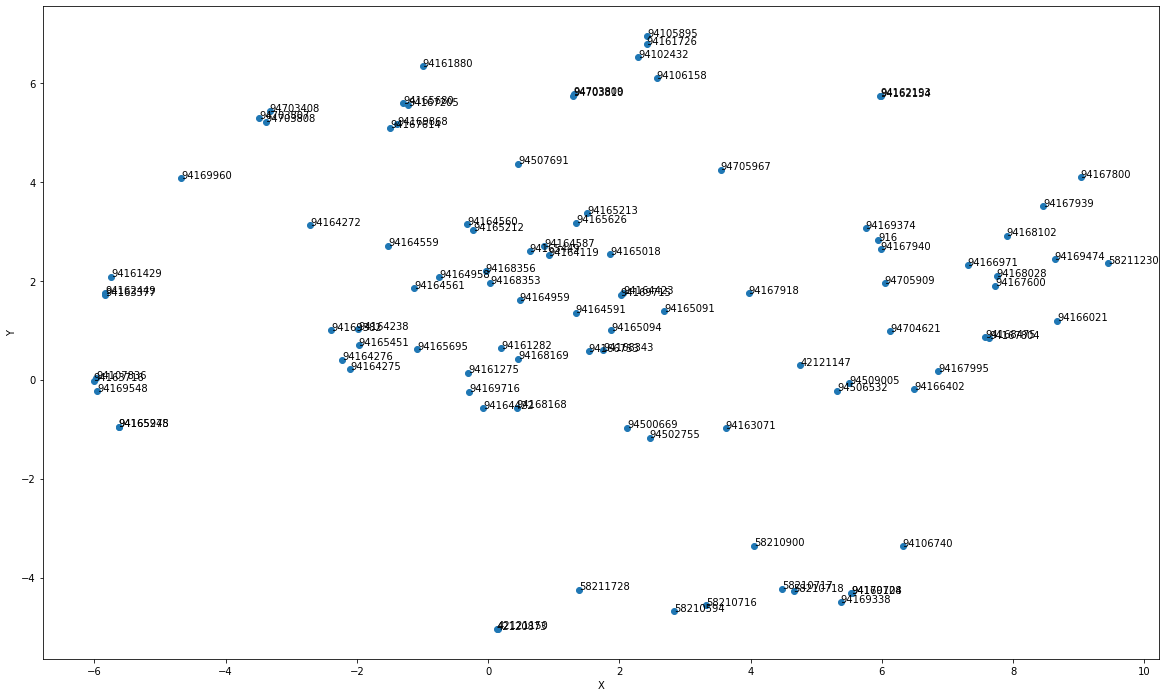

In [18]:
# Assuming your dataframe is called 'df'
fig = plt.figure(figsize=(20, 12))
plt.scatter(tsne_result['X'], tsne_result['Y'])

# Adding labels to the points
for x, y, product in zip(tsne_result['X'], tsne_result['Y'], tsne_result['product_code [None]']):
    plt.text(x, y, product)

# Setting labels for the axes
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

Cluster Analysis

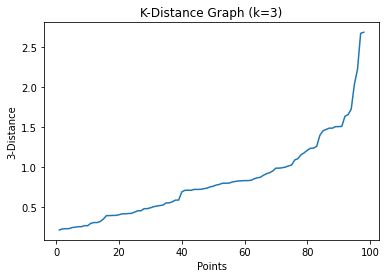

In [19]:
# Determine approximate value for eps and minPts by figuring out the elbow point of k-dist graph

tnse_data = tsne_result[['X', 'Y']].values
# Calculate the k-distance graph
k = 3  # Choose the value of k for the k-distance graph
nn = NearestNeighbors(n_neighbors=k)
nn.fit(tnse_data)
distances, indices = nn.kneighbors(tnse_data)

# Sort the distances
sorted_distances = np.sort(distances[:, k-1])

# Plot the k-distance graph
plt.plot(range(1, len(tnse_data)+1), sorted_distances)
plt.xlabel('Points')
plt.ylabel(f'{k}-Distance')
plt.title(f'K-Distance Graph (k={k})')
plt.show()

In [20]:
# apply DBSCAN
dbscan = DBSCAN(eps=0.7, min_samples=2)
dbscan.fit(tnse_data)
dbscan_labels = dbscan.labels_

dbscan_result = tsne_result
dbscan_result['Cluster'] = dbscan_labels
dbscan_result

dbscan_result.to_csv("data/cluster_result_" + datetime.today().strftime('%Y-%m-%d') + '.csv', sep=';', decimal = ".")

In [25]:
dbscan_result.loc[dbscan_result['Cluster'] == 4]['product_code [None]']

11    94102432
12    94105895
13    94106158
19    94161726
Name: product_code [None], dtype: Int64

Plotting Cluster Distribution

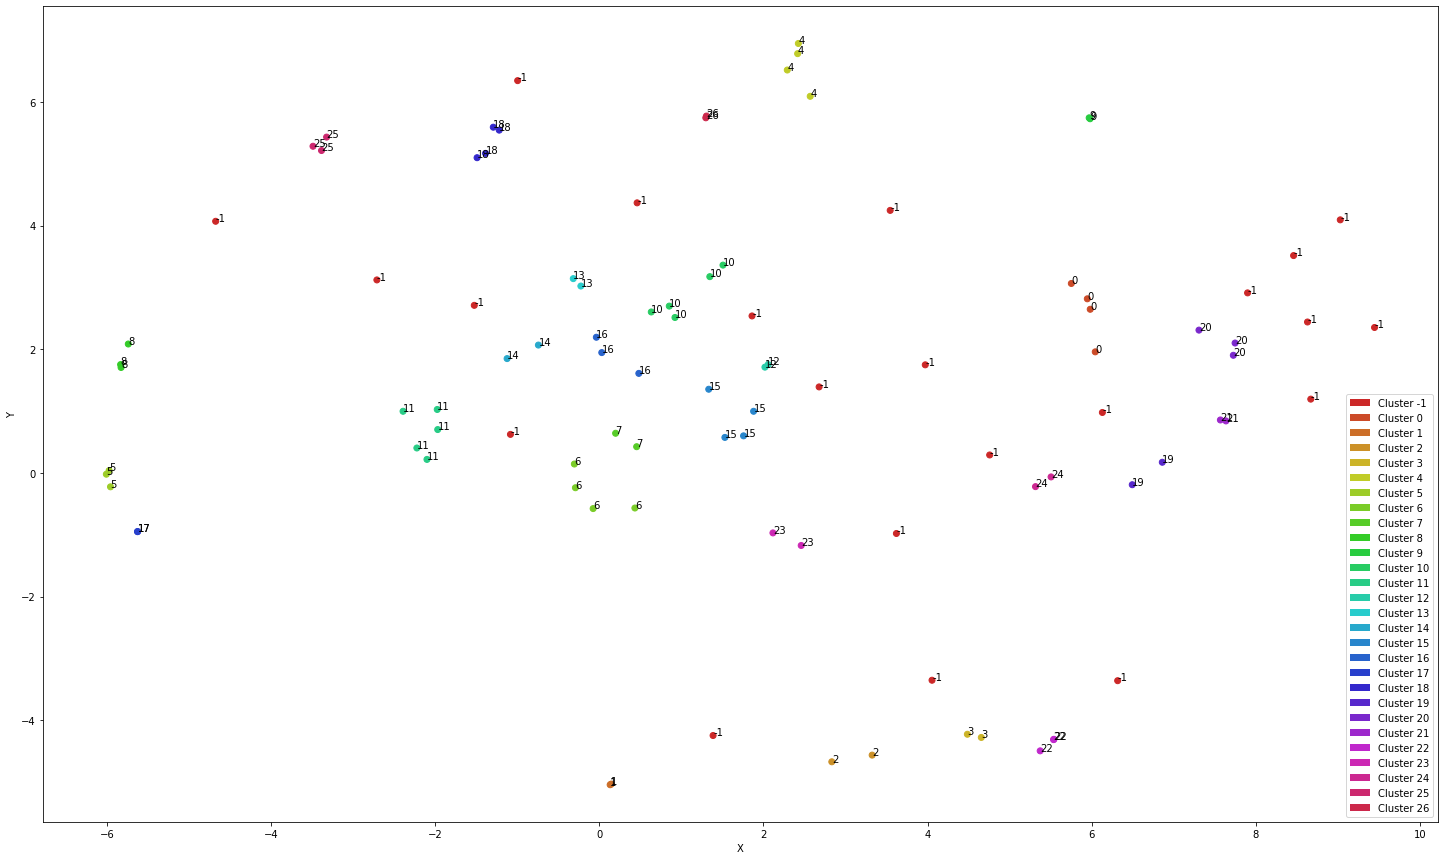

In [23]:
# Generating <number of clusters> maximal different colors
def generate_distinct_colors(num_colors):
    colors = []
    hue_values = [i / num_colors for i in range(num_colors)]
    saturation = 0.8
    value = 0.8

    for hue in hue_values:
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        rgb_int = [int(val * 255) for val in rgb]
        rgb_str = '#{:02x}{:02x}{:02x}'.format(rgb_int[0], rgb_int[1], rgb_int[2])
        colors.append(rgb_str)

    return colors

# Determine the number of unique clusters
num_colors = dbscan_result['Cluster'].nunique()

# Generate distinct colors for the clusters
cluster_colors = generate_distinct_colors(num_colors)

# Determine figure size
fig = plt.figure(figsize=(25, 15))

# Create a ListedColormap with the cluster colors
cmap = ListedColormap(cluster_colors)

# Create a scatter plot with the custom colormap
scatter = plt.scatter(dbscan_result['X'], dbscan_result['Y'], c=dbscan_result['Cluster'], cmap=cmap)

# Add labels to the data points
for x, y, product, cluster in zip(dbscan_result['X'], dbscan_result['Y'], dbscan_result['product_code [None]'], dbscan_result['Cluster']):
    plt.text(x, y, f'{cluster}')

# Set labels for the axes
plt.xlabel('X')
plt.ylabel('Y')

# Get the unique clusters in sorted order
sorted_clusters = sorted(dbscan_result['Cluster'].unique())

# Create legend handles for each cluster with respective color
legend_handles = [Patch(facecolor=cluster_colors[i], label='Cluster {}'.format(cluster))
                  for i, cluster in enumerate(sorted_clusters)]

# Create a separate legend with all clusters
plt.legend(handles=legend_handles)

# Show the plot
plt.show()


Evaluate Quality of Clustering

In [24]:
dbscan_result_for_silhouette = dbscan_result.loc[dbscan_result['Cluster'] != -1]
silhouette_avg = silhouette_score(dbscan_result_for_silhouette[['X', 'Y']], dbscan_result_for_silhouette['Cluster'])
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.7086485
